# **Thư viện**

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.dates as mdates
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# **Dữ liệu**

In [18]:
df = pd.read_csv("../data/processed/EUR_VND_Exchange_Rate.csv", parse_dates=["Date"])
df["Date"] = pd.to_datetime(df["Date"])
timestamps = df["Date"].values   
df = df.set_index('Date')
df = df.select_dtypes(include=[np.number]).fillna(0).astype(np.float32)

df.tail()

,Sell
Date,
2025-04-07,29106.519531
2025-04-08,29215.210938
2025-04-09,29443.519531
2025-04-10,29178.759766
2025-04-11,29775.689453


# **Tạo Lags**


In [19]:
lags = 30
for i in range(1, lags + 1):
    df[f'lag_{i}'] = df['Sell'].shift(i)
df.dropna(inplace=True)  


In [20]:
df

,Sell,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-01,26024.470703,26024.470703,26024.470703,25993.859375,26085.720703,26034.900391,26034.900391,26034.900391,26054.089844,26092.029297,...,26261.199219,26147.939453,26190.960938,26121.769531,26018.949219,25936.230469,25936.230469,25936.230469,26506.550781,26506.550781
2020-05-02,26024.470703,26024.470703,26024.470703,26024.470703,25993.859375,26085.720703,26034.900391,26034.900391,26034.900391,26054.089844,...,26261.199219,26261.199219,26147.939453,26190.960938,26121.769531,26018.949219,25936.230469,25936.230469,25936.230469,26506.550781
2020-05-03,26024.470703,26024.470703,26024.470703,26024.470703,26024.470703,25993.859375,26085.720703,26034.900391,26034.900391,26034.900391,...,26261.199219,26261.199219,26261.199219,26147.939453,26190.960938,26121.769531,26018.949219,25936.230469,25936.230469,25936.230469
2020-05-04,26230.000000,26024.470703,26024.470703,26024.470703,26024.470703,26024.470703,25993.859375,26085.720703,26034.900391,26034.900391,...,26238.789062,26261.199219,26261.199219,26261.199219,26147.939453,26190.960938,26121.769531,26018.949219,25936.230469,25936.230469
2020-05-05,26166.019531,26230.000000,26024.470703,26024.470703,26024.470703,26024.470703,26024.470703,25993.859375,26085.720703,26034.900391,...,26253.960938,26238.789062,26261.199219,26261.199219,26261.199219,26147.939453,26190.960938,26121.769531,26018.949219,25936.230469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-07,29106.519531,29106.519531,29106.519531,29106.519531,29245.750000,28437.330078,28516.390625,28459.009766,28362.949219,28362.949219,...,28560.130859,28438.750000,28438.750000,28438.750000,28507.570312,28509.990234,28534.269531,28427.619141,28468.929688,28468.929688
2025-04-08,29215.210938,29106.519531,29106.519531,29106.519531,29106.519531,29245.750000,28437.330078,28516.390625,28459.009766,28362.949219,...,28730.009766,28560.130859,28438.750000,28438.750000,28438.750000,28507.570312,28509.990234,28534.269531,28427.619141,28468.929688
2025-04-09,29443.519531,29215.210938,29106.519531,29106.519531,29106.519531,29106.519531,29245.750000,28437.330078,28516.390625,28459.009766,...,28707.859375,28730.009766,28560.130859,28438.750000,28438.750000,28438.750000,28507.570312,28509.990234,28534.269531,28427.619141


In [21]:
X = df.drop(columns=['Sell']).values
y = df['Sell'].values

# **Train/Test**

In [22]:
timestamps = df.dropna().index 

train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Lấy timestamps tương ứng
train_timestamps = timestamps[:train_size]
test_timestamps = timestamps[train_size:]


# **Huấn luyện mô hình XGBoost**


In [23]:
def train_xgb(X_train, y_train, model_path):
    """
    Huấn luyện XGBoost và lưu mô hình với tham số tối ưu
    """
    # param_grid = {
    #     'n_estimators': [100, 200, 300, 400, 500],
    #     'max_depth': [3, 5, 7, 10],
    #     'learning_rate': [0.01, 0.05, 0.1],
    #     'subsample': [0.8, 1.0],
    #     'colsample_bytree': [0.8, 1.0],
    #     'reg_alpha': [0, 0.1, 1],
    #     'reg_lambda': [0, 0.1, 1]
    # }

    param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0],
    'reg_lambda': [1]
    }   
    
    
    model = xgb.XGBRegressor(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    joblib.dump(best_model, model_path)

    return best_model

In [24]:
model_path = r"D:\eur-vnd-exchange-rate\models\XGBoost\best_xgb_prices.pkl"
best_model = train_xgb(X_train, y_train, model_path)
best_model.get_params()

Fitting 5 folds for each of 8 candidates, totalling 40 fits


{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.05,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

# **Đánh giá mô hình**

In [25]:
y_pred_test = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)
mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100

print("Đánh giá mô hình XGBoost")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")

Đánh giá mô hình XGBoost
MAE: 79.1467
MSE: 15527.2344
RMSE: 124.6083
MAPE: 0.2824%


# **Dự đoán và Thực tế**


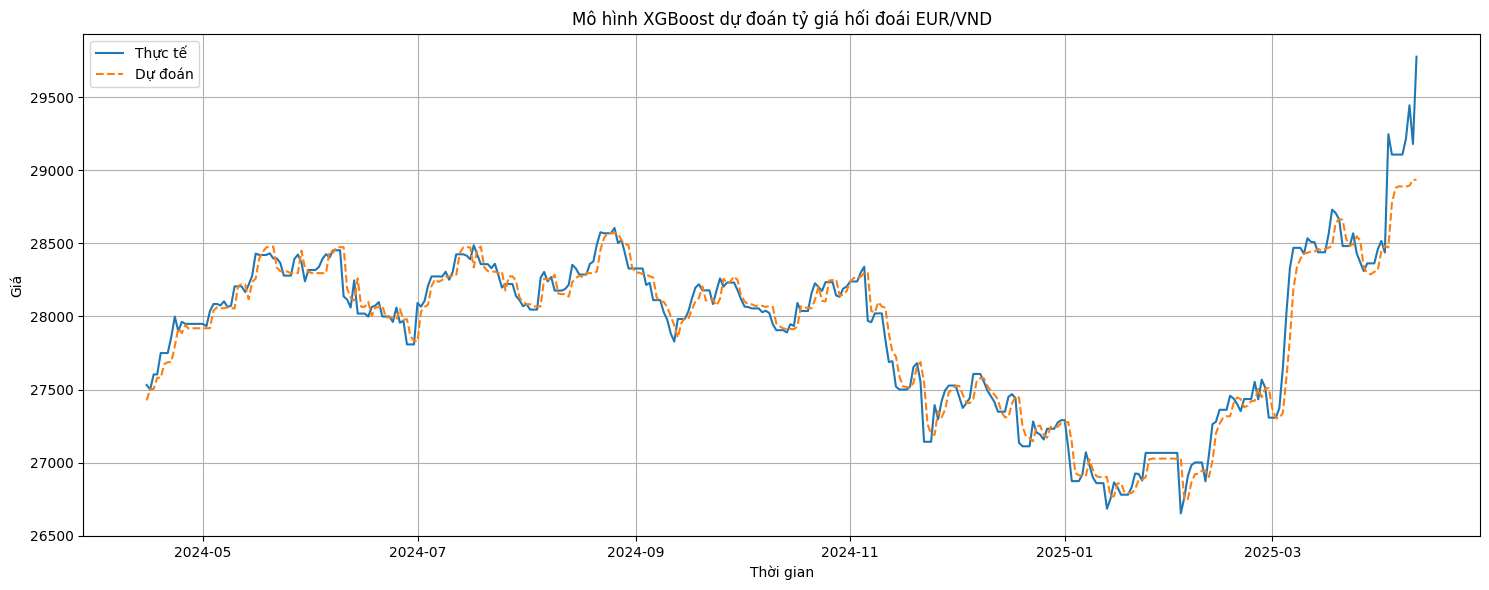

In [34]:
y_pred_test = best_model.predict(X_test)

# Đảm bảo test_timestamps là datetime
test_timestamps = pd.to_datetime(test_timestamps)

plt.figure(figsize=(15, 6))
plt.plot(test_timestamps, y_test, label="Thực tế")
plt.plot(test_timestamps, y_pred_test, label="Dự đoán", linestyle="dashed")

plt.xlabel("Thời gian")
plt.ylabel("Giá")
plt.title("Mô hình XGBoost dự đoán tỷ giá hối đoái EUR/VND")
plt.grid(True)

plt.legend()
plt.tight_layout()
plt.show()


In [37]:
pip install tabulate


Note: you may need to restart the kernel to use updated packages.


In [36]:
# In kết quả dự đoán 7 ngày tiếp theo
future_df = pd.DataFrame({
    'Ngày': future_dates.strftime('%Y-%m-%d'),
    'Giá dự đoán (EUR/VND)': [round(p, 4) for p in future_preds]
})

print("Dự đoán tỷ giá EUR/VND cho 7 ngày tiếp theo:")
print(future_df.to_string(index=False))


Dự đoán tỷ giá EUR/VND cho 7 ngày tiếp theo:
      Ngày  Giá dự đoán (EUR/VND)
2025-04-12           28468.828125
2025-04-13           28473.814453
2025-04-14           28463.208984
2025-04-15           28460.326172
2025-04-16           28522.632812
2025-04-17           28692.595703
2025-04-18           28661.597656


In [38]:
from tabulate import tabulate

# Tạo DataFrame chứa kết quả
future_df = pd.DataFrame({
    'Ngày': future_dates.strftime('%Y-%m-%d'),
    'Giá dự đoán (EUR/VND)': [round(p, 4) for p in future_preds]
})

# In bảng đẹp
print("Dự đoán tỷ giá EUR/VND cho 7 ngày tiếp theo:\n")
print(tabulate(future_df, headers='keys', tablefmt='fancy_grid', showindex=False))


Dự đoán tỷ giá EUR/VND cho 7 ngày tiếp theo:

╒════════════╤═════════════════════════╕
│ Ngày       │   Giá dự đoán (EUR/VND) │
╞════════════╪═════════════════════════╡
│ 2025-04-12 │                 28468.8 │
├────────────┼─────────────────────────┤
│ 2025-04-13 │                 28473.8 │
├────────────┼─────────────────────────┤
│ 2025-04-14 │                 28463.2 │
├────────────┼─────────────────────────┤
│ 2025-04-15 │                 28460.3 │
├────────────┼─────────────────────────┤
│ 2025-04-16 │                 28522.6 │
├────────────┼─────────────────────────┤
│ 2025-04-17 │                 28692.6 │
├────────────┼─────────────────────────┤
│ 2025-04-18 │                 28661.6 │
╘════════════╧═════════════════════════╛


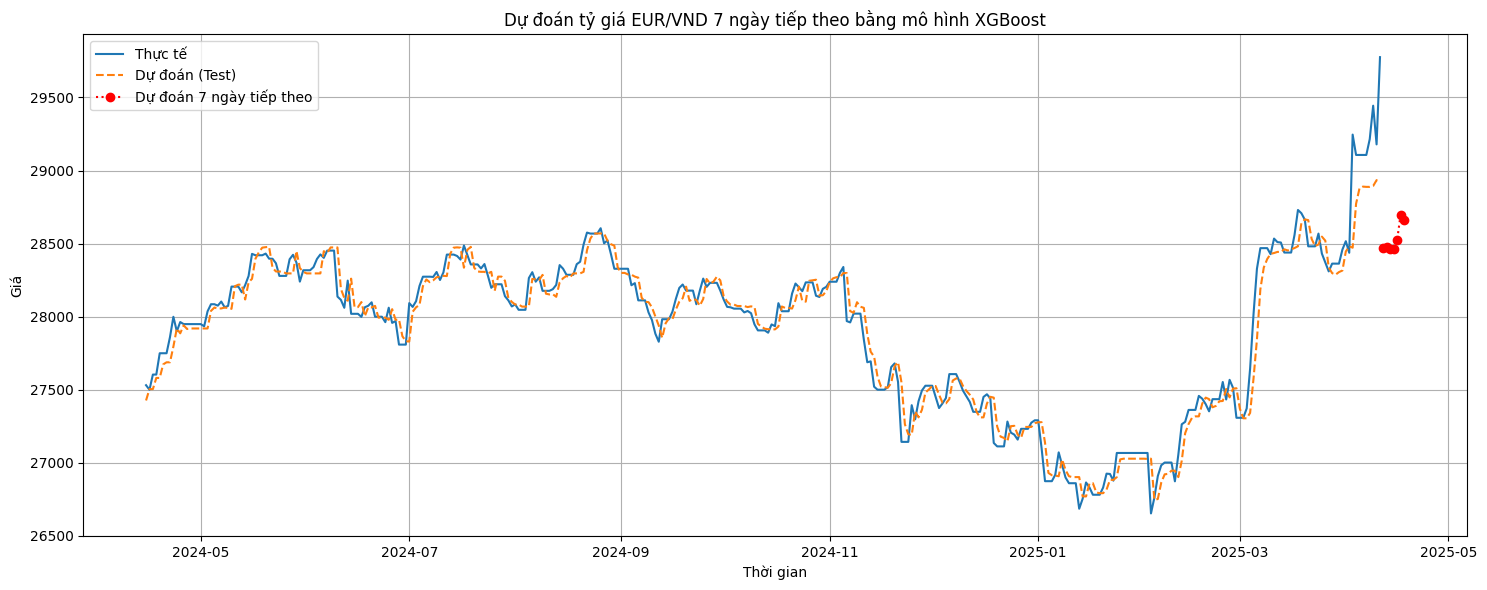

Dự đoán tỷ giá 7 ngày tiếp theo:
        Ngày   Giá dự đoán
0 2025-04-12  28468.830078
1 2025-04-13  28473.814453
2 2025-04-14  28463.208984
3 2025-04-15  28460.326172
4 2025-04-16  28522.634766
5 2025-04-17  28692.593750
6 2025-04-18  28661.597656


In [35]:
# **Dự đoán 7 ngày tiếp theo**
future_days = 7
last_known = df['Sell'][-lags:].tolist()  # Lấy 30 giá trị gần nhất

future_preds = []

for _ in range(future_days):
    # Tạo đặc trưng từ các giá trị gần nhất
    input_features = np.array(last_known[-lags:]).reshape(1, -1)
    
    # Dự đoán
    next_pred = best_model.predict(input_features)[0]
    future_preds.append(next_pred)
    
    # Thêm vào danh sách để dự đoán tiếp theo
    last_known.append(next_pred)

# Tạo dãy thời gian cho 7 ngày tiếp theo
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)

# Vẽ biểu đồ kết quả
plt.figure(figsize=(15, 6))
plt.plot(test_timestamps, y_test, label="Thực tế")
plt.plot(test_timestamps, y_pred_test, label="Dự đoán (Test)", linestyle="dashed")
plt.plot(future_dates, future_preds, label="Dự đoán 7 ngày tiếp theo", color='red', linestyle='dotted', marker='o')

plt.xlabel("Thời gian")
plt.ylabel("Giá")
plt.title("Dự đoán tỷ giá EUR/VND 7 ngày tiếp theo bằng mô hình XGBoost")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# In kết quả dự đoán
future_df = pd.DataFrame({'Ngày': future_dates, 'Giá dự đoán': future_preds})
print("Dự đoán tỷ giá 7 ngày tiếp theo:")
print(future_df)


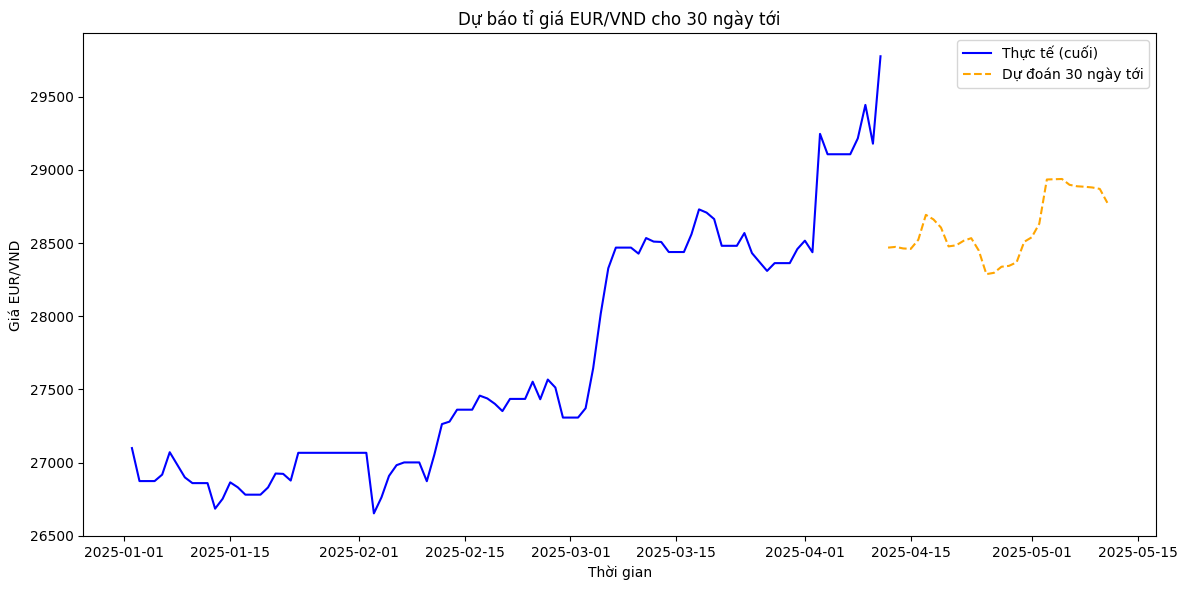

In [27]:
from datetime import timedelta

# Lấy 30 giá trị gần nhất để bắt đầu dự báo
last_known = df['Sell'].values[-lags:].tolist()  # danh sách 30 giá trị gần nhất

future_preds = []  # lưu dự đoán
future_dates = []  # lưu ngày tương ứng

# Ngày bắt đầu là ngày cuối cùng trong dữ liệu
last_date = df.index[-1]

for i in range(30):
    # Tạo input với 30 giá trị lag gần nhất
    input_features = np.array(last_known[-lags:]).reshape(1, -1)

    # Dự đoán ngày tiếp theo
    pred = best_model.predict(input_features)[0]

    # Lưu kết quả
    future_preds.append(pred)
    last_known.append(pred)  # cập nhật vào danh sách để tiếp tục dùng cho lần sau
    future_dates.append(last_date + timedelta(days=i+1))  # ngày dự đoán tiếp theo

# Chuyển thành DataFrame để tiện sử dụng
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Sell': future_preds
}).set_index('Date')

# Vẽ biểu đồ nối tiếp
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100:], df['Sell'].values[-100:], label='Thực tế (cuối)', color='blue')
plt.plot(future_df.index, future_df['Predicted_Sell'], label='Dự đoán 30 ngày tới', color='orange', linestyle='--')

plt.xlabel("Thời gian")
plt.ylabel("Giá EUR/VND")
plt.title("Dự báo tỉ giá EUR/VND cho 30 ngày tới")
plt.legend()
plt.tight_layout()
plt.show()
